Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result. 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from models.convolution import Convolution

from utils.sr_utils import *

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark =False
#dtype = torch.cuda.FloatTensor
dtype = torch.FloatTensor


# Load image and baselines

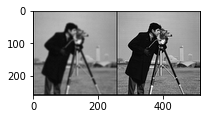

(1, 256, 256)

In [2]:
# Starts here
path_LR_image = 'data/sr/Cameraman256_gauss.png'
path_HR_image = 'data/sr/Cameraman256.png'
img_lr_pil, img_lr_np = get_image(path_LR_image, -1)
img_hr_pil, img_hr_np = get_image(path_HR_image, -1)
plot_image_grid([img_lr_np,img_hr_np])
img_hr_np.shape

# Set up parameters and net

In [3]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='udf'
kernel_path ='data/sr/kernel_gauss.mat'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

PLOT = True

In [4]:
net_input = get_noise(input_depth, INPUT, (img_hr_pil.size[1], img_hr_pil.size[0])).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet
net = get_net(input_depth, 'skip', pad, n_channels=1, skip_n33d=128, skip_n33u=128, skip_n11=4, 
              num_scales=5, upsample_mode='bilinear').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)
img_LR_var = np_to_torch(img_lr_np).type(dtype)

convolution = Convolution(n_planes=1, kernel_type=KERNEL_TYPE, kernel_path=kernel_path, preserve_size=True).type(dtype)

# Define closure and optimize

In [ ]:
def closure():
    global i, net_input
    
    reg_noise_std = 0.01
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    print('out_HR', torch_to_np(out_HR).shape)
    out_LR = convolution(out_HR)

    total_loss = mse(out_LR, img_LR_var) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward()

    # Log
    psnr_LR = compare_psnr(img_lr_np, torch_to_np(out_LR))
    psnr_HR = compare_psnr(img_hr_np, torch_to_np(out_HR))
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if PLOT and i % 100 == 0:
        out_HR_np = torch_to_np(out_HR)
        plot_image_grid([img_hr_np, np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)

    i += 1
    
    return total_loss

Starting optimization with ADAM


/Users/Vivien/anaconda3/envs/dip/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/Users/Vivien/anaconda3/envs/dip/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


out_HR (1, 256, 256)


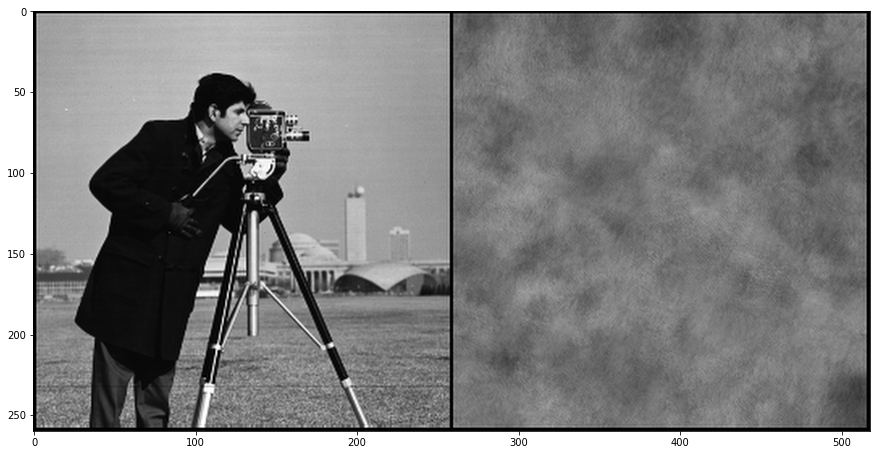

out_HR (1, 256, 256)
out_HR (1, 256, 256)SNR_LR 10.888   PSNR_HR 10.377 
out_HR (1, 256, 256)SNR_LR 11.497   PSNR_HR 10.949 
out_HR (1, 256, 256)SNR_LR 9.481   PSNR_HR 9.125 
out_HR (1, 256, 256)SNR_LR 13.997   PSNR_HR 13.077 
out_HR (1, 256, 256)SNR_LR 13.682   PSNR_HR 12.822 
out_HR (1, 256, 256)SNR_LR 14.237   PSNR_HR 13.275 
out_HR (1, 256, 256)SNR_LR 14.733   PSNR_HR 13.671 
out_HR (1, 256, 256)SNR_LR 15.100   PSNR_HR 13.957 
out_HR (1, 256, 256)SNR_LR 15.621   PSNR_HR 14.353 
out_HR (1, 256, 256)SNR_LR 16.403   PSNR_HR 14.927 
out_HR (1, 256, 256)SNR_LR 16.977   PSNR_HR 15.327 
out_HR (1, 256, 256)SNR_LR 17.604   PSNR_HR 15.752 
out_HR (1, 256, 256)SNR_LR 18.268   PSNR_HR 16.184 
out_HR (1, 256, 256)SNR_LR 18.439   PSNR_HR 16.292 
out_HR (1, 256, 256)SNR_LR 18.852   PSNR_HR 16.552 
out_HR (1, 256, 256)SNR_LR 19.120   PSNR_HR 16.716 
out_HR (1, 256, 256)SNR_LR 19.319   PSNR_HR 16.827 
out_HR (1, 256, 256)SNR_LR 19.502   PSNR_HR 16.931 
out_HR (1, 256, 256)SNR_LR 19.618   PSNR_HR 1

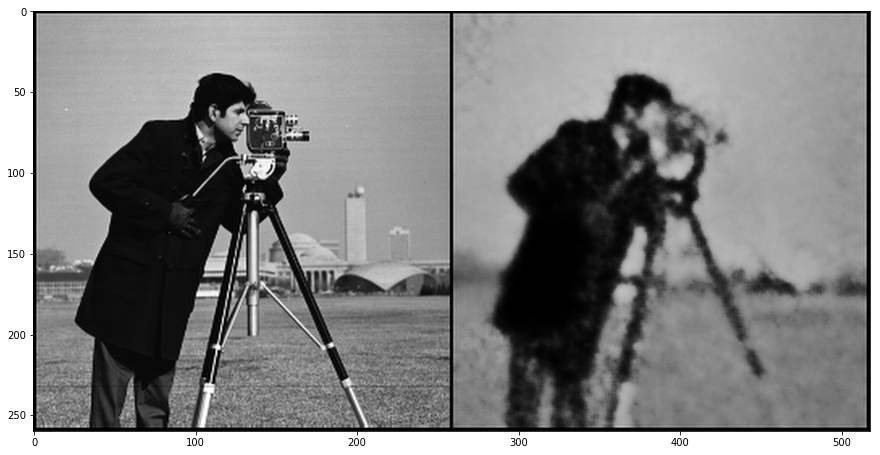

out_HR (1, 256, 256)
out_HR (1, 256, 256)SNR_LR 29.927   PSNR_HR 21.572 
out_HR (1, 256, 256)SNR_LR 29.895   PSNR_HR 21.583 


In [ ]:
psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
num_iter=2000
reg_noise_std = 0.03
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, img_hr_np.shape[1:])

# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
plot_image_grid([img_hr_np,
                 out_HR_np], factor=4, nrow=1);